In [1]:
# for installing packages using legacy code
!pip install setuptools

# The environment we will be working with
!pip install git+https://github.com/ParisaAligol/CityLearn-EVModel-Parisa@develop-ev

# For participant interactions (buttons)
!pip install ipywidgets

# To generate static figures
!pip install matplotlib
!pip install seaborn

# Provide standard RL algorithms
!pip install stable_baselines3
!pip install shimmy

  Cloning https://github.com/ParisaAligol/CityLearn-EVModel-Parisa (to revision develop-ev) to /tmp/pip-req-build-fcnde8uc
  Running command git clone --filter=blob:none --quiet https://github.com/ParisaAligol/CityLearn-EVModel-Parisa /tmp/pip-req-build-fcnde8uc
  Running command git checkout -b develop-ev --track origin/develop-ev
  Switched to a new branch 'develop-ev'
  Branch 'develop-ev' set up to track remote branch 'develop-ev' from 'origin'.
  Resolved https://github.com/ParisaAligol/CityLearn-EVModel-Parisa to commit 27692f21eaa7ea96e343f8ddabc0a03d4718b382
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.2 MB/s eta 0:00:00
  Created wheel for CityLearn: filename=CityLearn-2.0b3-py3-none-any.whl size=18139893 sha256=ac28fa5ba031c4ea65302c20a7d81b2a47873f122cec617f5

In [2]:
import os
import numpy as np
import pandas as pd
import shutil
from stable_baselines3 import SAC
from citylearn.agents.rbc import BasicRBC
from citylearn.callback import SaveDataCallback
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.energy_model import ElectricVehicle, ZERO_DIVISION_CAPACITY
from citylearn.reward_function import RewardFunction
from citylearn.utilities import read_json, write_json
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [3]:
from google.colab import files

# Use the files.upload() function to upload a file
uploaded = files.upload()

Saving Building_1.csv to Building_1.csv
Saving Building_1_EV_1.csv to Building_1_EV_1.csv
Saving Building_1_EV_2.csv to Building_1_EV_2.csv
Saving Building_1_EV_3.csv to Building_1_EV_3.csv
Saving Building_1_EV_4.csv to Building_1_EV_4.csv
Saving Building_1_EV_5.csv to Building_1_EV_5.csv
Saving Building_2.csv to Building_2.csv
Saving Building_2_EV_1.csv to Building_2_EV_1.csv
Saving Building_2_EV_2.csv to Building_2_EV_2.csv
Saving Building_2_EV_3.csv to Building_2_EV_3.csv
Saving Building_3.csv to Building_3.csv
Saving Building_3_EV_1.csv to Building_3_EV_1.csv
Saving Building_4.csv to Building_4.csv
Saving Building_4_EV_1.csv to Building_4_EV_1.csv
Saving Building_4_EV_2.csv to Building_4_EV_2.csv
Saving Building_4_EV_3.csv to Building_4_EV_3.csv
Saving Building_4_EV_4.csv to Building_4_EV_4.csv
Saving Building_4_EV_5.csv to Building_4_EV_5.csv
Saving Building_5.csv to Building_5.csv
Saving Building_5_EV_1.csv to Building_5_EV_1.csv
Saving Building_6.csv to Building_6.csv
Saving Bui

In [4]:
# Specify the destination directory path in the Colab environment
destination_directory = '/usr/local/lib/python3.10/dist-packages/citylearn/data/citylearn_challenge_2023_phase_2/'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Move the uploaded file to the destination directory
for filename, content in uploaded.items():
    file_path = os.path.join(destination_directory, filename)
    with open(file_path, 'wb') as f:
        f.write(content)

print("File moved to the specific directory successfully.")

File moved to the specific directory successfully.


In [5]:
SCHEMA_TEMPLATE = 'citylearn_challenge_2023_phase_2'
TARGET_DATASET_DIRECTORY = 'ev_test_data'
SCHEMA_FILEPATH = os.path.join(TARGET_DATASET_DIRECTORY, SCHEMA_TEMPLATE, 'schema.json')

In [6]:
uploaded = files.upload()

Saving building_1_pv.zip to building_1_pv.zip


In [7]:
# Specify the destination directory path in the Colab environment
destination_directory = '/usr/local/lib/python3.10/dist-packages/citylearn/Results/Building_1_PV/'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Move the uploaded file to the destination directory
for filename, content in uploaded.items():
    file_path = os.path.join(destination_directory, filename)
    with open(file_path, 'wb') as f:
        f.write(content)

print("File moved to the specific directory successfully.")

File moved to the specific directory successfully.


In [13]:
# Copy an existing dataset
if os.path.isdir(TARGET_DATASET_DIRECTORY):
    shutil.rmtree(TARGET_DATASET_DIRECTORY)
else:
    pass

DataSet.copy(SCHEMA_TEMPLATE, TARGET_DATASET_DIRECTORY)
schema = read_json(SCHEMA_FILEPATH)

model_path = '/usr/local/lib/python3.10/dist-packages/citylearn/Results/Building_1_PV/building_1_pv.zip'

In [14]:
class CustomReward(RewardFunction):
    def __init__(self, env: CityLearnEnv):
        super().__init__(env)

    def calculate(self):
        reward_list = []

        for b in self.env.buildings:
            e = b.net_electricity_consumption[-1]
            reward = 0.0

            for s in [b.electrical_storage] + b.electric_vehicles:
                if not isinstance(s, ElectricVehicle) or (isinstance(s, ElectricVehicle) and s.schedule.availability[-1] == 1):
                    c = s.capacity_history[0]
                    s = s.soc[-1]/c
                    reward += -(1.0 + np.sign(e)*s)*abs(e) if c > ZERO_DIVISION_CAPACITY else 0.0
                else:
                    pass

            reward_list.append(reward)

        if self.env.central_agent:
            reward = [sum(reward_list)]
        else:
            reward = reward_list

        return reward

In [15]:
# SAC
env = CityLearnEnv(schema, central_agent=True, reward_function=CustomReward)
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)
custom_objects = {
    'lr_schedule': lambda x: .003,
}
model = SAC.load(model_path, custom_objects=custom_objects)

observations = env.reset()
actions_list = []
rewards_list = []

while not env.done:
    actions, _ = model.predict(observations, deterministic=True)
    observations, rewards, _, _ = env.step(actions)
    actions_list.append(actions)
    rewards_list.append(rewards)

display(env.evaluate())

,cost_function,value,name,level
0,annual_peak_average,1.015098,District,district
1,carbon_emissions_total,1.011335,District,district
2,cost_total,1.013143,District,district
3,daily_peak_average,1.024425,District,district
4,discomfort_delta_average,0.000000,District,district
...,...,...,...,...
79,discomfort_too_cold_proportion,NaN,Building_7,building
80,discomfort_too_hot_proportion,NaN,Building_7,building
81,discomfort_delta_minimum,0.000000,Building_7,building
82,discomfort_delta_maximum,0.000000,Building_7,building


In [16]:
# RBC
rbc_env = CityLearnEnv(schema)
rbc_model = BasicRBC(rbc_env)
rbc_model.learn(episodes=1)
display(rbc_env.evaluate())

,cost_function,value,name,level
0,annual_peak_average,1.005567,District,district
1,carbon_emissions_total,1.008763,District,district
2,cost_total,1.020000,District,district
3,daily_peak_average,1.203389,District,district
4,discomfort_delta_average,0.000000,District,district
...,...,...,...,...
79,discomfort_too_cold_proportion,NaN,Building_7,building
80,discomfort_too_hot_proportion,NaN,Building_7,building
81,discomfort_delta_minimum,0.000000,Building_7,building
82,discomfort_delta_maximum,0.000000,Building_7,building


In [23]:
def plot_building_guide(env):
    """Plots building load and generation profiles."""

    column_count_limit = 4
    building_count = len(env.buildings)
    row_count = math.ceil((building_count + 1) / column_count_limit)  # Add 1 for the sum chart
    column_count = min(column_count_limit, building_count)
    figsize = (4.0 * column_count, 1.75 * row_count)
    fig, axes = plt.subplots(row_count, column_count, figsize=figsize)

    # Calculate the sum of the total for each time step across all buildings
    total_sum = [0] * len(env.buildings[0].energy_simulation.non_shiftable_load)
    for b in env.buildings:
        total_sum = [total_sum[i] + b.energy_simulation.non_shiftable_load[i] for i in range(len(total_sum))]

    for i, (ax, b) in enumerate(zip(axes.flat, env.buildings)):
        y1 = b.energy_simulation.non_shiftable_load
        y2 = b.pv.get_generation(b.energy_simulation.solar_generation)
        x = range(len(y1))
        ax.plot(x, y1, label='Load')
        ax.plot(x, y2, label='Generation')
        ax.set_title(b.name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
        else:
            ax.legend().set_visible(False)

    # Create a new subplot for the sum chart
    ax_sum = axes.flat[-1]
    ax_sum.plot(x, total_sum, label='Total Sum', color='red')
    ax_sum.set_title('Total Sum')
    ax_sum.set_xlabel('Time step')
    ax_sum.set_ylabel('kWh')
    ax_sum.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax_sum.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    # Hide any remaining empty subplots
    for ax in axes.flat[building_count:]:
        ax.set_visible(False)

    plt.tight_layout()
    return fig

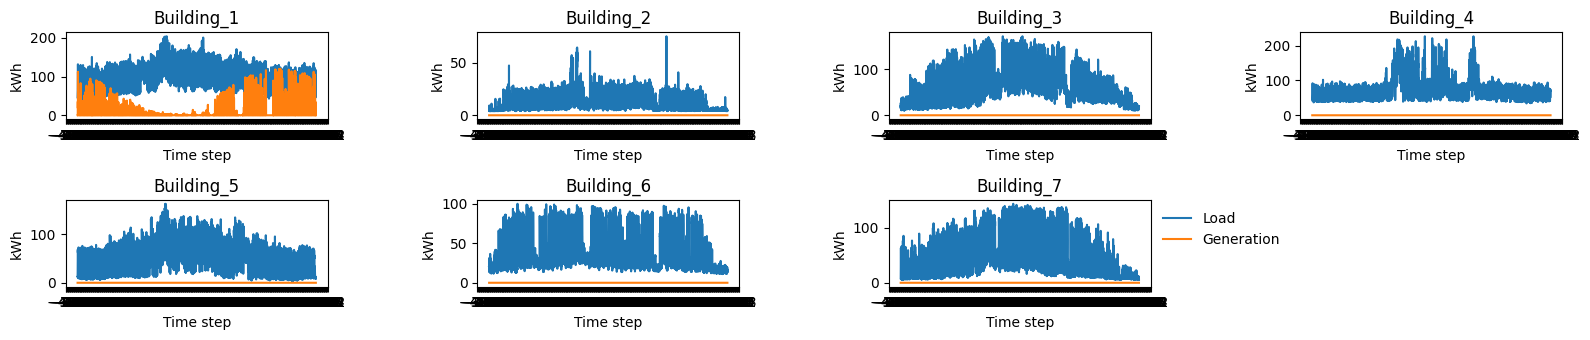

In [24]:
plot_building_guide(rbc_env)
plt.savefig('case_study.png', format='png', dpi=600)
plt.show()

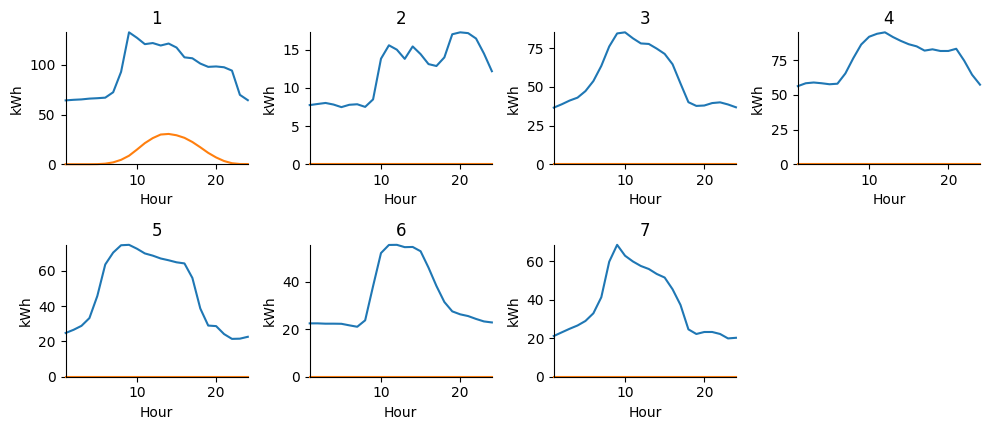

In [20]:
# Average daily profile
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

building_count = len(env.buildings)
column_count_limit = 4
row_count = math.ceil(building_count/column_count_limit)
column_count = min(column_count_limit, building_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(2.5*column_count, 2.2*row_count))

for ax in fig.axes[building_count:]:
    fig.delaxes(ax)

for i, (ax, b) in enumerate(zip(fig.axes, env.buildings)):
    data = pd.DataFrame({
        'load': b.energy_simulation.non_shiftable_load,
        'generation': abs(b.solar_generation),
        'hour': b.energy_simulation.hour
    })
    data['day_index'] = (data.index/24).astype(int)
    data = data.groupby('hour')[['load', 'generation']].mean()
    x = data.index
    y1 = data['load']
    y2 = data['generation']
    ax.plot(x, y1, color='tab:blue', label='load', clip_on=False)
    ax.plot(x, y2, color='tab:orange', label='generation', clip_on=False)
    ax.set_title(i + 1)
    ax.margins(0)
    ax.set_xlabel('Hour')
    ax.set_ylabel('kWh')

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

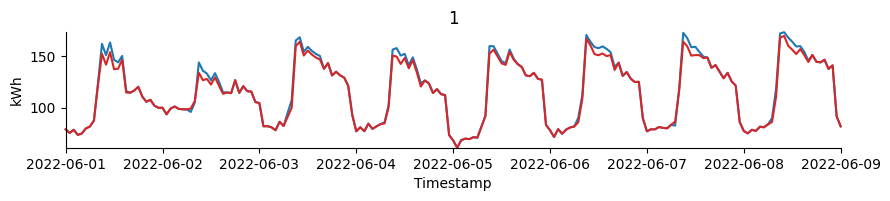

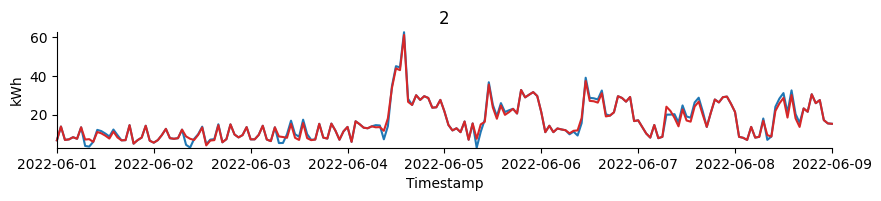

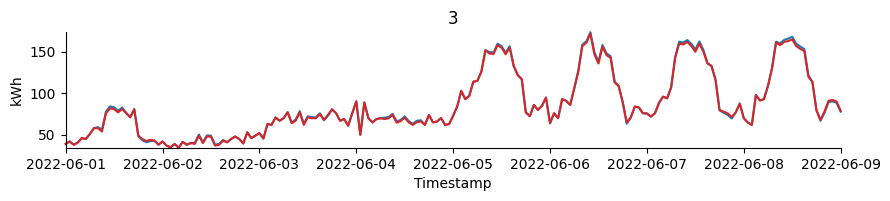

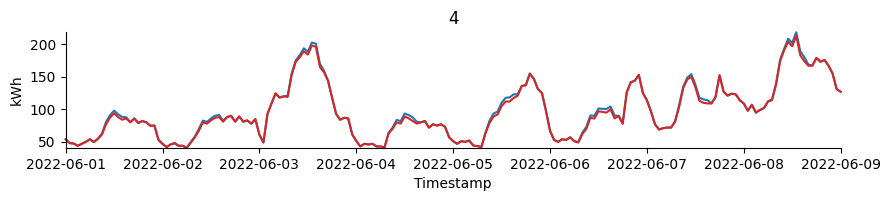

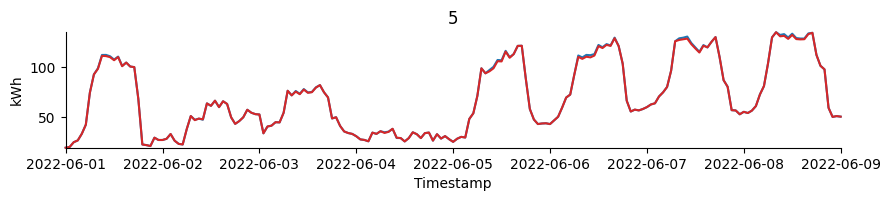

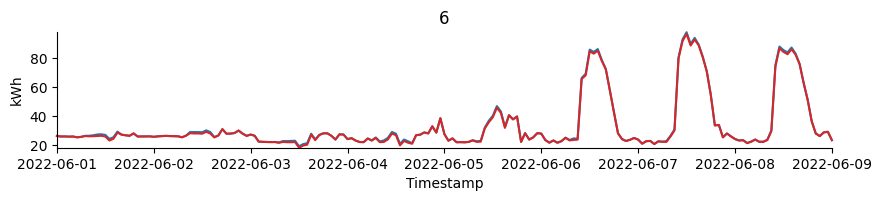

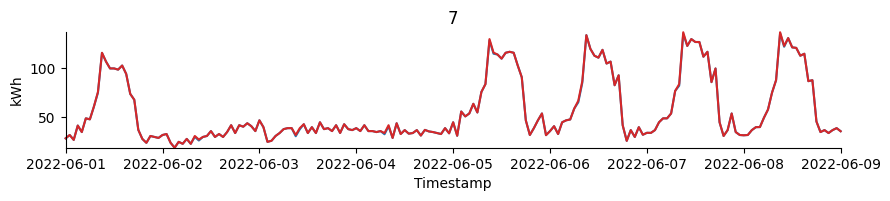

In [25]:
# Profile snapshot
from datetime import timedelta

start_timestamp = pd.to_datetime('2022-06-01')
end_timestamp = start_timestamp + timedelta(days=8)
date_range = pd.date_range('2022-01-01', '2022-12-31 23:00:00', freq='H')

for i, b in enumerate(env.buildings):
    data = pd.DataFrame({
        'with_storage': b.net_electricity_consumption,
        'without_storage': b.net_electricity_consumption_without_storage,
        'timestamp': date_range
    })
    data = data[(data['timestamp']>=start_timestamp) & (data['timestamp']<=end_timestamp)]
    x = data['timestamp'].tolist()
    y1 = data['with_storage'].tolist()
    y2 = data['without_storage'].tolist()
    fig, ax = plt.subplots(1, 1, figsize=(10, 1.5))
    ax.plot(x, y1, color='tab:blue', clip_on=False, label='with storage')
    ax.plot(x, y2, color='tab:red', clip_on=False, label='without storage')
    ax.set_title(i + 1)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('kWh')
    ax.margins(0)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

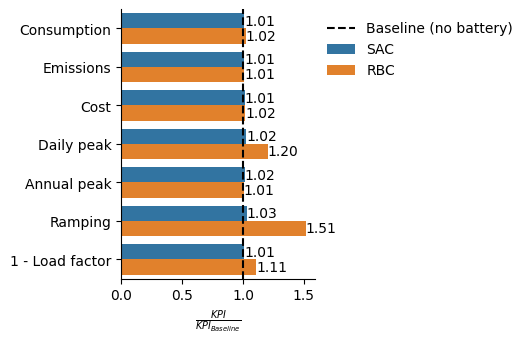

In [22]:
# District level KPI
import seaborn as sns

sac_data = env.evaluate()
rbc_data = rbc_env.evaluate()
sac_data['agent'] = 'SAC'
rbc_data['agent'] = 'RBC'
cost_functions = {
    'electricity_consumption_total': 'Consumption',
    'carbon_emissions_total': 'Emissions',
    'cost_total': 'Cost',
    'daily_peak_average': 'Daily peak',
    'annual_peak_average': 'Annual peak',
    'ramping_average': 'Ramping',
    'one_minus_load_factor_average': '1 - Load factor',
}
data = pd.concat([sac_data, rbc_data], ignore_index=True)
data = data[(data['level']=='district') & (data['cost_function'].isin(cost_functions.keys()))].copy()
data['label'] = data['cost_function'].map(lambda x: cost_functions[x])


fig, ax = plt.subplots(1, 1, figsize=(2.5, 3.5))
hue_order = ['SAC', 'RBC']
sns.barplot(x='value', y='label', data=data, hue='agent', order=cost_functions.values(), hue_order=hue_order, ax=ax)
ax.axvline(1.0, color='black', linestyle='--', label='Baseline (no battery)')
ax.set_xlabel(r'$\frac{KPI}{KPI_{Baseline}}$')
ax.set_ylabel(None)

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.2f}', ha='left', va='center')
ax.legend(
    bbox_to_anchor=(1.0,1.0),
    loc='upper left',
    framealpha=0,
    ncol=1
)

plt.show()